In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import Phylo, AlignIO

# The direction of time: rooting a tree

In the last part of this tutorial we'll discuss the problem of rooting a tree.

By picking a root, one defines a direction of time along branches. We'll discuss few commonly used methods to root a tree:
- midpoint rooting
- outgroup rooting
- rooting using information on collection times and reconstructing [timetrees](https://en.wikipedia.org/wiki/Timetree)

## Rooted vs unrooted trees

Trees inferred by the canonical tree-building programs are typically "rooted", meaning they have singled out a particular node in the tree to act as the "parent" of all other nodes.
However, as you saw in previous lectures, the models of evolution used to infer the tree are typically "time reversible", meaning they don't differentiate between past and future and the likelihood of the tree does not depent on the choice of root. And **while tree-building programs return a rooted tree, these trees are typically rooted arbitrarily**. This is an important point to keep in mind.

The two trees below are a rooted and unrooted version of the same tree.

![rooted tree example](assets/tree_rooted_example.png)
![unrooted tree example](assets/tree_unrooted_example.png)

How does one pick a root?

## Preliminary steps: loading our data

We will experiment with rooting the three that we build in the previous tutorial part. We can start by loading and visualizing the tree.

Our tree has two relatively long arms, and the roots sits in the middle.


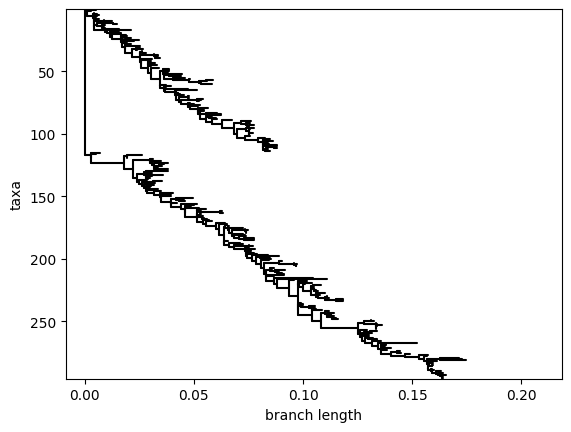

In [2]:
tree = Phylo.read("results/tree.nwk", "newick")
tree.ladderize()

Phylo.draw(tree, label_func=lambda x: None)

In our case we have informations that we could use to verify how good our rooting is: we are considering a fast-evolving virus, and we have samples spread over several decades, with know collection times. This is a very special case, but one in which we can verify the choice of root. A good rooting is one in which samples close to the root are more ancient, and samples further away from the root are more recent.

To verify how the current rooting is, we can load the metadata information, containing the collection date of each sample, and scatter-plot the date against the distance of each sample from the root.

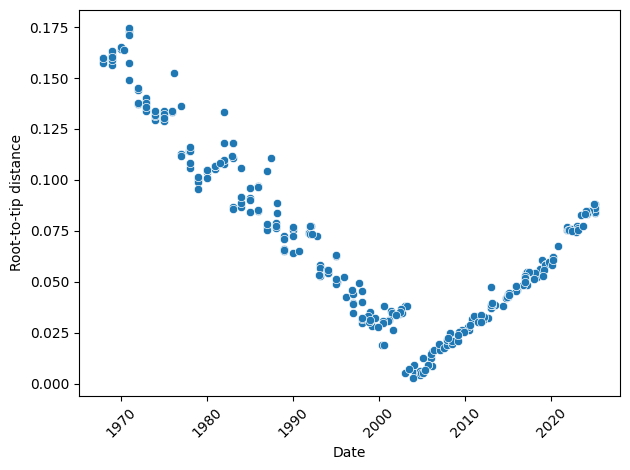

In [3]:
# load metadata
metadata = pd.read_csv("results/h3n2_metadata.csv", parse_dates=["date"], index_col=0)

def rtt_dist_vs_date_scatterplot(tree, metadata):
    # calculate root-to-tip distances
    depths = {k.name: v for k, v in tree.depths().items()}

    idxs = metadata.index
    date = metadata["date"]
    rtt_dist = [depths[idx] for idx in idxs]

    sns.scatterplot(x=date, y=rtt_dist)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Root-to-tip distance")
    plt.tight_layout()
    plt.show()

rtt_dist_vs_date_scatterplot(tree, metadata)

With the current rooting, the most recent sample sit at intermediate distance from the root, while samples closer to the root are older. This is a sign of a bad rooting point.

# Common ways of picking a root

Below we discuss few common ways of picking a root.

## Midpoint rooting

Midpoint rooting picks the root to be half-way between the two tips that are furthest away of each other.
This choice of root is often natural when the samples have evolved from a common ancestor at similar rates and with similar divergence times. In this case you expect all tips to have a similar distance from the tree root, and the midpoint between the two most diverged tips is an approximation of that. There are also variations of mid-point rooting minimize the variance if root-to-tip distance. One of the advantages of midpoint rooting is that it does not require any additional information, such as outgroup or collection times.

In our case this method is not expected to work well, since we are violating one core assumptions: samples are not equally diverged from the root, since we sample the evolution of the H3N2 flu A virus from the pandemic onset (close to the root) to the present day (far from the root). In our case this method erroneously places the root in the middle of the tree.


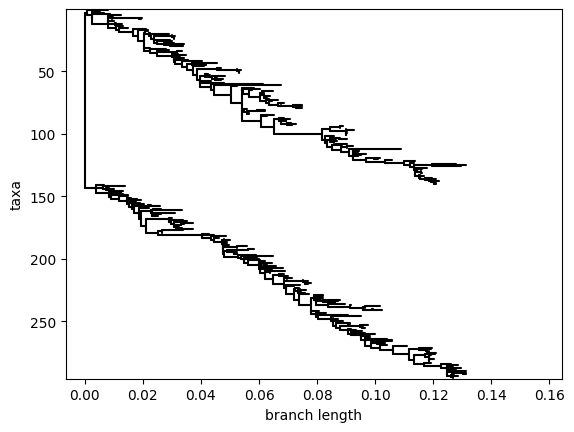

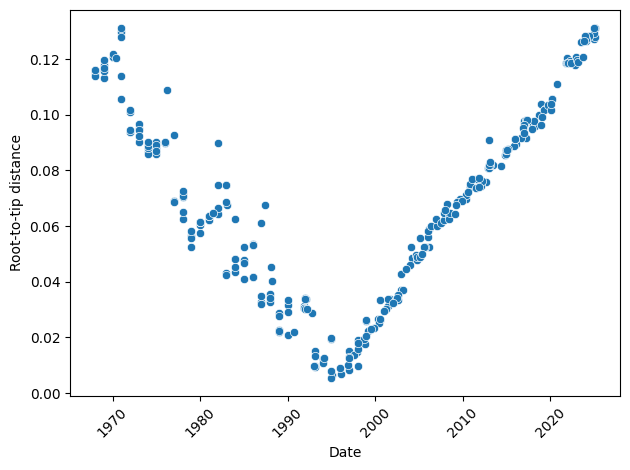

In [4]:
tree.root_at_midpoint()
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

rtt_dist_vs_date_scatterplot(tree, metadata)

## Outgroup rooting

Another common way of rooting a tree is by using an outgroup, i.e. a sequence that is clearly further diverged from the dataset of interest (the ingroup) than any other sequence in the dataset.
For example, if you were investigating how different mice species are related to each other, you could use the genetic sequence of a rat as an outgroup.
All sequences from the ingroup should form one clade and the point where the outgroup joins the ingroup is a good estimate of the common ancestor of the ingroup. 

See this illustration from [U Manchester](http://www.bioinf.man.ac.uk/resources/phase/manual/node59.html)

![outgroup rooting](assets/outgroup_rooting.png)

In our case for simplicity we will not add an extra sequence as an outgroup, but as an approximation we will use the oldest sample in our dataset as an outgroup. This will be the sample that should be closer to the root.

Indeed, we see that with this choice of root, sample times are well correlated with the distance from the root.


In [5]:
metadata.sort_values("date").head()

,description,date,country,len,ambiguous,collection_year
accession,,,,,,
CY032993.1,Influenza A virus (A/Hong Kong/1-1-MA-20E/1968...,1968-01-01,Hong Kong,1716,0,1968.0
CY033529.1,Influenza A virus (A/Hong Kong/1-9-MA21-3/1968...,1968-01-01,Hong Kong,1726,0,1968.0
CY033505.1,Influenza A virus (A/Hong Kong/1-1-MA-12/1968(...,1968-01-01,Hong Kong,1714,0,1968.0
CY033025.1,Influenza A virus (A/Hong Kong/1-5/1968(H3N2))...,1968-01-01,Hong Kong,1720,0,1968.0
KY321927.1,Influenza A virus (A/Hong Kong/01/1968(H3N2)) ...,1968-01-01,China,1765,0,1968.0


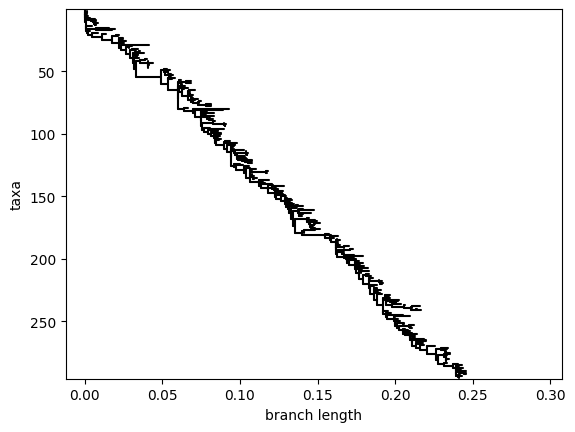

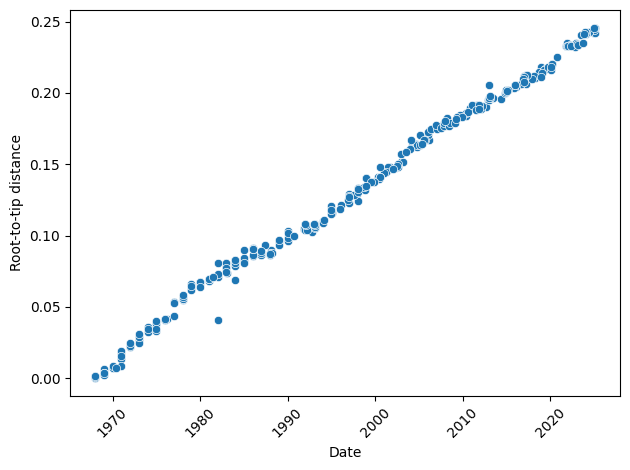

In [6]:
# we can use one of the original Hong-Kong sequences as an outgroup
# outgroup = "CY034012.1"
outgroup = "CY033025.1"

tree.root_with_outgroup(outgroup)
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

rtt_dist_vs_date_scatterplot(tree, metadata)

## Rapidly evolving viruses and timetrees

As discussed above, our example comes from a very special case: a rapidly evolving virus.

Rapidly-evolving viruses adapt rapidly enough that they accumulate significant numbers of mutations over a few years, and we can follow their evolution in real time. Example include SARS-CoV-2, Influenza viruses, and other RNA viruses. They typically accumulate between 10 and 40 mutations per genome per year.

As mentioned above, in these cases information on sampling time can be used to inform the choice of the root. We expect the distance of the individual sequences from the root of the tree to increase with their sampling date: later sequences should have more differences compared to the ancestor. We can use this expectation to more accurately estimate the root. Specifically, we expect that the distance $d_i$ of genome $i$ from the ancestor should grow linearly with the time $t_i - T_{MRCA}$ since the common ancestor 
$$
d_i = \mu (t_i - T_{MRCA}) + \epsilon
$$
where $\epsilon$ captures the stochasticity of the process (more precisely, we expect the number of mutations $d_i$ to be Poisson distributed with mean $\mu (t_i - T_{MRCA})$. 

This expectation ca be used for two purposes.

### Optimization of the root position

The position of the root can be optimized efficiently without exhaustively searching for the minimum of 
$$
\sum_i (d_i - \mu(t_i-T_{MRCA}))^2
$$
for all possible choices of roots. The best-fitting slope $\mu$ serves as an estimate of the evolutionary rate, i.e. the number of mutations that a genome accumulates per unit time. 

Such a search for the root is implemented in several packages, including [TreeTime](https://treetime.biozentrum.unibas.ch/). This algorithm will place the root such that the root-to-tip vs time regression is straight:

![treetime](assets/treetime.png)

The slope of the regression line is an estimate of the evolutionary rate, that is the rate at which mutations accumulate in the sequences. 

### Time trees and time-scaled phylogenies

The same expectation can be used to estimate the time of internal nodes in the tree, and build a time-scaled phylogeny.

You can find more details on how this can be done in the [treetime paper](https://academic.oup.com/ve/article/4/1/vex042/4794731), but the general idea is that you can combine time constraints that come from the sampling times of sequences with the expectation of evolutionary times that come from their genetic distance. Similarly to what we saw for the Fitch parsimony algorithm, you can propagate this information back through the tree towards the root, to find the most likely time for each internal node, then assign the most likely time to the root. Then the information can be propagated towards the leaves, and progressively pick the most likely time for each branch and internal node.

![treetime bck](assets/treetime_backprop.png)
![treetime fwd](assets/treetime_fwdprop.png)

From [this presentation](https://neherlab.org/202104_computational_biology.html#/)


### Application to our data

We can apply this approach to our data, and use _TreeTime_ to reconstruct a time-scaled phylogeny, and estimate the root position that best fits the sampling times.

In [7]:
from treetime import TreeTime
from treetime.utils import parse_dates
from treetime.treetime import plot_vs_years

tree_fname = "results/tree.nwk"
aln_fname = "results/h3n2_coding.aln.fa"
metadata_fname = "results/h3n2_metadata.csv"
dates = parse_dates(metadata_fname, name_col="accession", date_col="date")
# dates = metadata["date"]
tt = TreeTime(gtr='Jukes-Cantor', tree = tree_fname, use_fft=False,
              aln = aln_fname, verbose = 1, dates = dates)


Attempting to parse dates...
	Using column 'accession' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.



3.06	TreeTime.reroot: with method or node: least-squares

3.06	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

4.49	###TreeTime.run: INITIAL ROUND

17.83	TreeTime.reroot: with method or node: least-squares

17.84	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

18.43	###TreeTime.run: rerunning timetree after rerooting

31.19	###TreeTime.run: ITERATION 1 out of 2 iterations

31.19	DEPRECATION WARNING. TreeTime.resolve_polytomies: You are resolving
     	polytomies using the old 'greedy' mode. This is not well suited for large
     	polytomies. Stochastic resolution will become the default in future
     	versions. To switch now, rerun with the flag `--stochastic-resolve`. To
     	keep using the greedy method in the future, run with `--greedy-resolve`

46.45	###TreeTime.run: ITERATION 2 out of 2 iterations


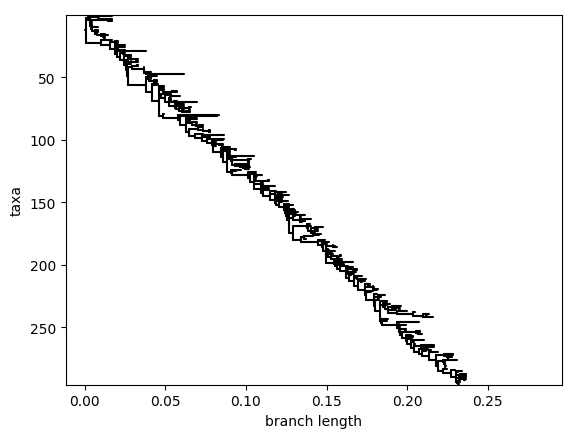

clock rate: 0.00407


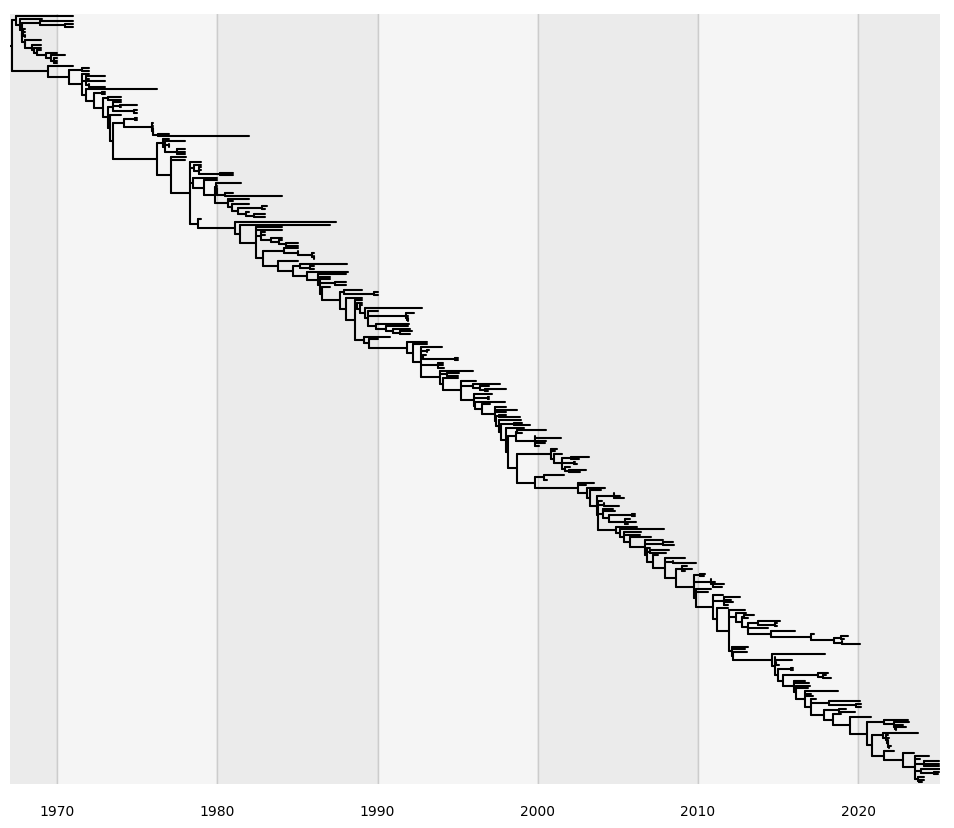

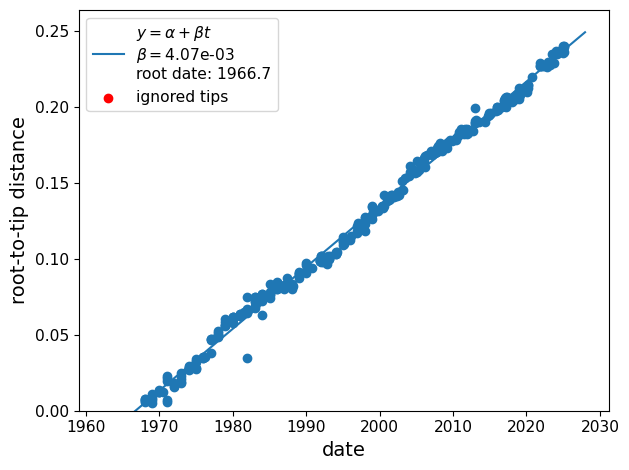

In [8]:
# rerooting can be done along with the tree time inference
tt.run(root="best", branch_length_mode='input', max_iter=2)

# each node is now at a position that correspond to the given or inferred date
# the units of branch length are still clock rate.
Phylo.draw(tt.tree, label_func=lambda x:'')

# treetime implements a convenience function to plot timetrees
plot_vs_years(tt, label_func=lambda x:"")

tt.plot_root_to_tip()
print("clock rate: %1.5f"%tt.date2dist.clock_rate)
plt.show()